<a href="https://colab.research.google.com/github/NHirt32/LLM-News-Digest/blob/dev/API_LLM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Welcome to the API-powered News Summarization Project. This tool leverages the OpenAI API and a news source API to gather, analyze, and categorize current news articles from selected countries. The project aims to provide concise, relevant news summaries with a clear breakdown by category, helping users stay informed on major topics at a glance.

# Project Setup and Prerequisites
Before starting, make sure all necessary libraries are installed and ready for use. This project uses the following libraries:

    requests: For making HTTP requests to external APIs.
    dotenv: For securely managing environment variables.
    openai: For interacting with the OpenAI API.
    ipywidgets and jupyter_ui_poll: For creating interactive UI elements within the notebook.
    matplotlib: For data visualization.
    re: For regular expression operations on text data.

Run the following command to install any missing packages:

In [1]:
!pip install python-dotenv openai jupyter_ui_poll

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.6 MB/s eta 0:00:00


Next, import the required libraries:

In [2]:
# For API requests
import requests
# For mounting files and securing sensitive data
from google.colab import drive
import os
from dotenv import load_dotenv
# For OpenAI requests
import openai
# For interactive UI
import ipywidgets as widgets
from IPython.display import display, Markdown
import time
from jupyter_ui_poll import ui_events
# For string processing
import re
# For data visualization
import matplotlib.pyplot as plt

# Environment Setup
We use .env files to securely load API keys and other sensitive information. The environment file is stored on Google Drive for ease of access across sessions. This section handles mounting the drive and loading required keys for API interactions.

In [3]:
drive.mount('/content/drive')
env_path = '/content/drive/MyDrive/API-LLM-Project/.env'
load_dotenv(env_path)
# API Keys
news_key = os.getenv("NEWS_API_KEY")
openai.api_key = os.getenv("OPENAI_API_KEY")

Mounted at /content/drive


# Country Selection
To tailor news content, please select a country from the dropdown list. This will filter the news articles according to your specified region.

In [4]:
# Define the dropdown widget with a placeholder option
country_dropdown = widgets.Dropdown(
    options=[
        ('Select a Country', 'select'),
        ('United States', 'US')
    ],
    value='select',  # default value
    description='Country:',
)

display(country_dropdown)

# Essentially a loop that will alternate between polling ui events and sleeping until the user makes a selection
with ui_events() as poll:
  while country_dropdown.value == 'select':
    poll(10)
    time.sleep(0.1)

Dropdown(description='Country:', options=(('Select a Country', 'select'), ('United States', 'US')), value='sel…

# Fetching Top Headlines
Using the selected country, we query the News API for the latest headlines. The response is parsed to combine article titles and descriptions, which are then sent to the OpenAI model for summarization.

In [5]:
# Top URLs syntax: url?country={chosen_country}&apiKey=API_KEY
top_headlines_url = 'https://newsapi.org/v2/top-headlines'
temp_country = country_dropdown.value
news_params = {
    'country': temp_country,
    'apiKey': news_key
}

news_response = requests.get(top_headlines_url, params = news_params)
# If the response from News API is not "OK" stop the execution of the project
if news_response.status_code != 200:
  raise RuntimeError(f"Error: {news_response.status_code}, {news_response.reason}")
# Converting request object to dictionary
news_data = news_response.json()
# Now we combine all titles and descriptions into a single legible string
combined_content = '\n\n'.join(
    f"Title: {article['title']} \n Description{article['description']}"
    for article in news_data['articles']
)

# Processing Articles with OpenAI
In this section, we’ll prepare and send the news data to OpenAI’s language model for summarization. Our aim is to categorize and condense the news articles into structured summaries under specified topics.

## Setting Up API Parameters
First, we define the API parameters, including the model to use, specific instructions for categorization, and a user message containing the combined article content. The parameters are carefully chosen to ensure the model categorizes articles into the topics: Politics, Economics, Social Issues, Environment, Technology, and Entertainment.

In [6]:
openai_params = {
    'model': 'gpt-4o',
    'messages': [
        {
            "role": "system",
            "content": (
                "You are an intelligent summarization assistant tasked with categorizing news articles into the specific sections: 'Politics', 'Economics', 'Social Issues', 'Environment', 'Technology', and 'Entertainment.' "
                "Each category should have a single numeric percentage assigned (e.g., 'Politics: 40%'). "
                "For each section with content, provide up to 3 bullet points summarizing the top 3 most relevant articles in that category. "
                "List articles as bullet points, using the format: '[Article Title] - [Source]: [Brief Summary]'. "
                "If a category has no articles, list it with a percentage of 0% and write 'No articles fit this category.' "
                "Ensure that any special characters, such as `$`, `#`, or `*`, are properly escaped for Markdown formatting (e.g., use `\$` for `$`).\n\n"
                "Do **not** create any categories other than 'Politics', 'Economics', 'Social Issues', 'Environment', 'Technology', and 'Entertainment.' "
                "Disregard content about weather, natural disasters, or other topics outside these specific categories, and do not create a 'Weather' category.\n\n"
                "Strictly follow this format for each response:\n\n"
                "- **Category Name: Percentage%**\n  1. Article Summary Bullet 1\n  2. Article Summary Bullet 2\n  3. Article Summary Bullet 3\n\n"
                "Example format:\n\n"
                "- **Politics: 40%**\n  1. Article Summary 1\n  2. Article Summary 2\n  3. Article Summary 3\n\n"
                "- **Economics: 20%**\n  No articles fit this category.\n\n"
                "Each response should include all categories listed, with clear headings, percentages, and article summaries as instructed."
            )
        },
        {
            "role": "user",
            "content": (
                f"Analyze the following articles and categorize them appropriately in the format specified. "
                f"The content is as follows:\n\n{combined_content}"
            )
        }
    ],
    'max_tokens': 1000,
    'temperature': 0
}

## Making the API Request

With the parameters set, we’re now ready to make the request to OpenAI’s API. The response from the model contains categorized summaries, which we’ll format and display. This step sends the articles to OpenAI for analysis, where the model organizes them according to our predefined categories.

If an error occurs (e.g., if the model fails to generate a response), an error message will be displayed to inform the user.

In [7]:
try:
  openai_response = openai.chat.completions.create(**openai_params)
except Exception as e:
  print(f"An error occured: {e}")
article_summary = openai_response.choices[0].message.content.strip()

# Data Visualization and Presentation
In this final section, we process and present the categorized article data for easy interpretation. Using regex, we extract the category names and their corresponding percentages from the generated summary. This data is stored in a dictionary, with categories containing no articles filtered out to ensure clean visuals.

To visualize the breakdown of news categories, we create two types of charts:

    Pie Chart: Provides an intuitive overview of the category distribution, allowing for quick comparison of each category’s weight.
    Bar Chart: Offers a straightforward view of each category’s percentage, highlighting the prominence of topics more clearly.

Finally, the complete article summary is displayed in Markdown format below the visualizations, presenting detailed insights into each category. This structured presentation helps users quickly grasp both the quantitative and qualitative aspects of the summarized news.

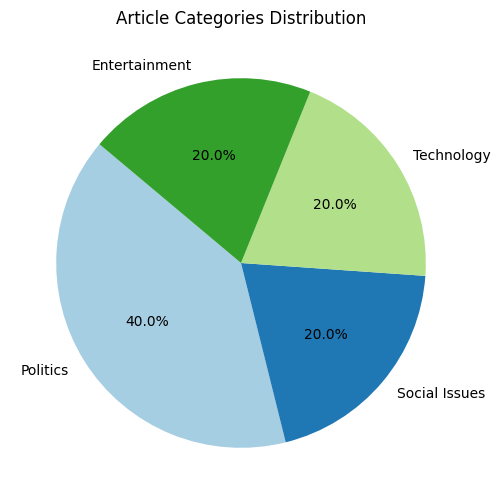

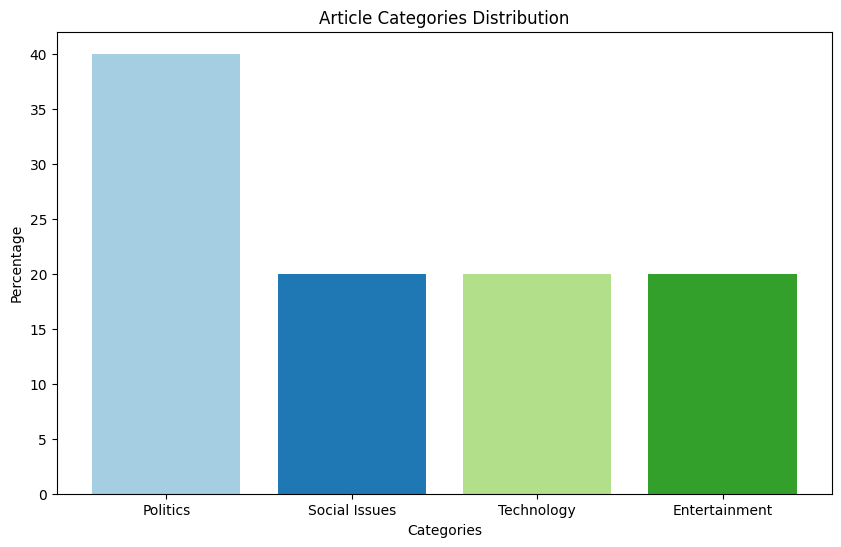

- **Politics: 40%**
  1. *Israel PM Netanyahu fires defence minister Gallant* - BBC.com: Netanyahu cites eroded trust as the reason for dismissing Gallant.
  2. *Trump votes in his "last" election: "I don't even want to think about losing"* - Axios: Trump expresses confidence in his electoral prospects.
  3. *Non-credible bomb threats against Atlanta-area polling places were from Russia, secretary of state says* - CNN: Georgia's Secretary of State reports Russian-originated threats disrupted voting.

- **Economics: 0%**
  No articles fit this category.

- **Social Issues: 20%**
  1. *Thirty-five Palestinians killed in Gaza, Israel issues new evacuation orders* - Reuters: Israeli military operations in Gaza result in casualties and new evacuation directives.
  2. *Israel hostage families attack Benjamin Netanyahu over Hamas leaks* - Financial Times: Families criticize Netanyahu over alleged leaks concerning hostages.
  3. *A week after Spain’s floods, families hold out hope that missing loved ones are alive* - The Associated Press: Families in Spain remain hopeful for missing relatives post-floods.

- **Environment: 0%**
  No articles fit this category.

- **Technology: 20%**
  1. *Apple News will let you watch election results from your lock screen* - The Verge: Apple News introduces live election results on lock screens.
  2. *LignoSat: First wood-panelled satellite launched into space* - BBC.com: Japan launches a satellite to test timber as a renewable material in space.
  3. *Watch 31st SpaceX Dragon cargo capsule arrive at the ISS today* - Space.com: SpaceX Dragon capsule scheduled to dock at the ISS.

- **Entertainment: 20%**
  1. *Tyka Nelson Dies: Singer And Prince’s Sister Was 64* - Deadline: Tyka Nelson, sister of Prince, passes away at 64.
  2. *Metal Slug Tactics is an odd mix of arcade shooter and grid strategy that works* - Ars Technica: A new game combines classic arcade elements with strategy gameplay.
  3. *Taylor Swift Appeared to Use One Word to Describe Chiefs’ OT Win Over Bucs* - Sports Illustrated: Taylor Swift comments on a football game, resonating with fans.

In [8]:
# Creating a regex to make a dictionary of the percentage breakdown of article varieties
category_matches = re.findall(r"-\s\*\*(.+):\s(\d+)%\*\*", article_summary)

# Creating the dictionary from the matches
category_dict = {category.strip(): int(percent) for category, percent in category_matches}

# Removing keys with a value of 0 (Empty article categories)
filtered_dict = {key: value for key, value in category_dict.items() if value != 0}

categories = list(filtered_dict.keys())
percentages = list(filtered_dict.values())

# Pie Chart
plt.figure(figsize=(8, 6))
plt.pie(percentages, labels=categories, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Article Categories Distribution')
plt.show()

# Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(categories, percentages, color=plt.cm.Paired.colors)
plt.title('Article Categories Distribution')
plt.xlabel('Categories')
plt.ylabel('Percentage')
plt.show()

# Markdown Article Summary
display(Markdown(article_summary))